In [1]:
from os import listdir
from os.path import isfile, join
import pandas as pd
import librosa


In [3]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from timeit import default_timer as timer
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Activation, MaxPooling1D, Dropout
from tensorflow.keras.utils import plot_model,to_categorical

In [4]:
class Diagnosis():
  def __init__ (self, id, diagnosis, image_path):
    self.id = id
    self.diagnosis = diagnosis 
    self.image_path = image_path   

In [5]:
def get_wav_files():
  audio_path = 'C:/Users/gf63/Desktop/Project_EDL_SML_AUML/Respiratory_Sound_Database/audio_and_txt_files/'
  files = [f for f in listdir(audio_path) if isfile(join(audio_path, f))]  #Gets all files in dir
  wav_files = [f for f in files if f.endswith('.wav')]  # Gets wav files 
  wav_files = sorted(wav_files)
  return wav_files, audio_path

In [6]:
def diagnosis_data():
  diagnosis = pd.read_csv(r"C:\Users\gf63\Desktop\Project_EDL_SML_AUML\Respiratory_Sound_Database\patient_diagnosis.csv")
  
  wav_files, audio_path = get_wav_files()
  diag_dict = { 101 : "URTI"}  
  diagnosis_list = []
  
  for index , row in diagnosis.iterrows():
    diag_dict[row[0]] = row[1]     

  c = 0
  for f in wav_files:
    diagnosis_list.append(Diagnosis(c, diag_dict[int(f[:3])], audio_path+f))  
    c+=1  

  return diagnosis_list

In [7]:
def audio_features(filename): 
  sound, sample_rate = librosa.load(filename)
  stft = np.abs(librosa.stft(sound))  
 
  mfccs = np.mean(librosa.feature.mfcc(y=sound, sr=sample_rate, n_mfcc=40),axis=1)
  chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate),axis=1)
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)
  contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate),axis=1)
  tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(sound), sr=sample_rate),axis=1)
    
  concat = np.concatenate((mfccs,chroma,mel,contrast,tonnetz))
  return concat

def data_points():
  labels = []
  images = []

  to_hot_one = {"COPD":0, "Healthy":1, "URTI":2, "Bronchiectasis":3, "Pneumonia":4, "Bronchiolitis":5, "Asthma":6, "LRTI":7}
  count = 0
  for f in diagnosis_data():
    print(count)
    labels.append(to_hot_one[f.diagnosis]) 
    images.append(audio_features(f.image_path))
    count+=1

  return np.array(labels), np.array(images)

In [15]:
def preprocessing(labels, images):    

  # Remove Asthma and LRTI
  images = np.delete(images, np.where((labels == 7) | (labels == 6))[0], axis=0) 
  labels = np.delete(labels, np.where((labels == 7) | (labels == 6))[0], axis=0)      

  # Split data
  X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=10)

  # Hot one encode the labels
  y_train = to_categorical(y_train)
  y_test = to_categorical(y_test)  

  # Format new data
  y_train = np.reshape(y_train, (y_train.shape[0], 6))
  X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
  y_test = np.reshape(y_test, (y_test.shape[0], 6))
  X_test = np.reshape(X_test, (X_test.shape[0], X_train.shape[1],  1))

  return X_train, X_test, y_train, y_test

In [ ]:
start = timer()

labels, images = data_points()
X_train, X_test, y_train, y_test = preprocessing(labels, images)

print('Time taken: ', (timer() - start))

In [10]:
model = Sequential()
model.add(Conv1D(64, kernel_size=5, activation='relu', input_shape=(193, 1)))

model.add(Conv1D(128, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(2)) 

model.add(Conv1D(256, kernel_size=5, activation='relu'))

model.add(Dropout(0.3))
model.add(Flatten())

model.add(Dense(512, activation='relu'))   
model.add(Dense(6, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=70, batch_size=200, verbose=1)

Epoch 1/70
4/4 [==============================] - 3s 583ms/step - loss: 6.0145 - accuracy: 0.6276 - val_loss: 1.7844 - val_accuracy: 0.8370
Epoch 2/70
4/4 [==============================] - 2s 536ms/step - loss: 3.4973 - accuracy: 0.5839 - val_loss: 1.4550 - val_accuracy: 0.8370
Epoch 3/70
4/4 [==============================] - 2s 467ms/step - loss: 3.0604 - accuracy: 0.8008 - val_loss: 1.8328 - val_accuracy: 0.8913
Epoch 4/70
4/4 [==============================] - 2s 442ms/step - loss: 3.5370 - accuracy: 0.8513 - val_loss: 1.3653 - val_accuracy: 0.9022
Epoch 5/70
4/4 [==============================] - 2s 476ms/step - loss: 2.4515 - accuracy: 0.8336 - val_loss: 0.7957 - val_accuracy: 0.8750
Epoch 6/70
4/4 [==============================] - 2s 493ms/step - loss: 1.2954 - accuracy: 0.8158 - val_loss: 0.5767 - val_accuracy: 0.8859
Epoch 7/70
4/4 [==============================] - 2s 580ms/step - loss: 0.6546 - accuracy: 0.8568 - val_loss: 0.4331 - val_accuracy: 0.8859
Epoch 8/70
4/4 [====

Accuracy: 94%
Loss: 0.1801



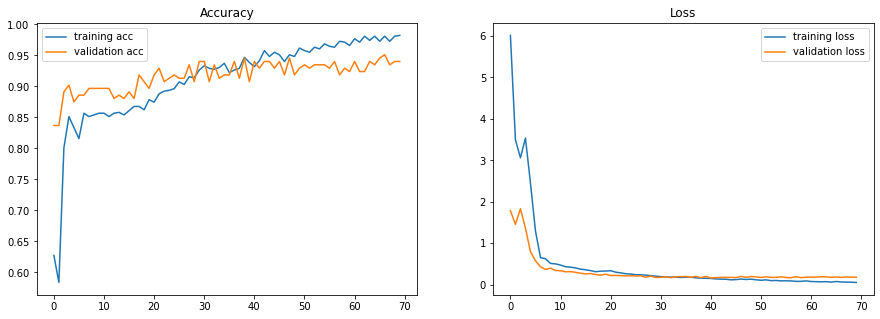

In [11]:
score = model.evaluate(X_test, y_test, batch_size=60, verbose=0)
print('Accuracy: {0:.0%}'.format(score[1]/1))
print("Loss: %.4f\n" % score[0])

# Plot accuracy and loss graphs
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label = 'training acc')
plt.plot(history.history['val_accuracy'], label = 'validation acc')
plt.legend()

plt.subplot(1,2,2)
plt.title('Loss')
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.legend()

                precision    recall  f1-score   support

          COPD       0.98      0.99      0.98       165
       Healthy       0.50      0.57      0.53         7
          URTI       0.33      0.25      0.29         4
Bronchiectasis       1.00      0.50      0.67         4
     Pneumoina       0.60      1.00      0.75         3
 Bronchiolitis       0.00      0.00      0.00         1

      accuracy                           0.94       184
     macro avg       0.57      0.55      0.54       184
  weighted avg       0.94      0.94      0.94       184



c:\Users\gf63\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\gf63\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\gf63\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

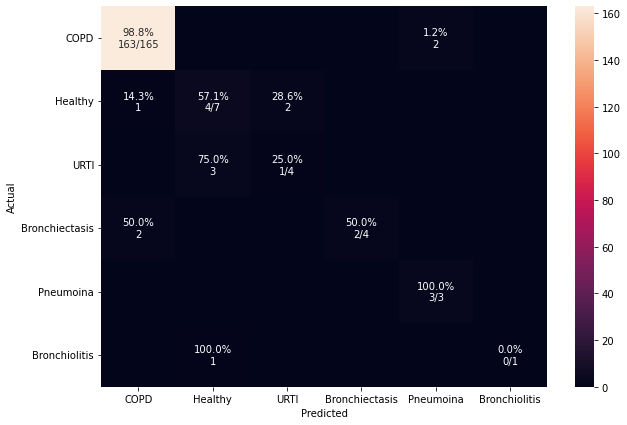

In [12]:
matrix_index = ["COPD", "Healthy", "URTI", "Bronchiectasis", "Pneumoina", "Bronchiolitis"]

preds = model.predict(X_test)
classpreds = np.argmax(preds, axis=1) # predicted classes 
y_testclass = np.argmax(y_test, axis=1) # true classes

cm = confusion_matrix(y_testclass, classpreds)
print(classification_report(y_testclass, classpreds, target_names=matrix_index))

# Get percentage value for each element of the matrix
cm_sum = np.sum(cm, axis=1, keepdims=True)
cm_perc = cm / cm_sum.astype(float) * 100
annot = np.empty_like(cm).astype(str)
nrows, ncols = cm.shape
for i in range(nrows):
    for j in range(ncols):
        c = cm[i, j]
        p = cm_perc[i, j]
        if i == j:
            s = cm_sum[i]
            annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
        elif c == 0:
            annot[i, j] = ''
        else:
            annot[i, j] = '%.1f%%\n%d' % (p, c)


# Display confusion matrix 
df_cm = pd.DataFrame(cm, index = matrix_index, columns = matrix_index)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
fig, ax = plt.subplots(figsize=(10,7))
sn.heatmap(df_cm, annot=annot, fmt='')

In [13]:
model.save("cnn.h5")